**This is a data science project on the Titanic Dataset. I will be using the dataset that can be found on: https://www.kaggle.com/c/titanic **

## Import Libraries

In [110]:
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings("ignore")

In [111]:
#common model algos
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import lightgbm as lgb


In [112]:
#for organizing the data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [113]:
#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns



## Import Data

In [114]:
#The data is imported from my local drive
df_raw = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
#Create a copy of the data so I don't mess with the original
df1 = df_raw.copy(deep = True)

data_cleaning = [df1, df_test]


In [115]:
#data_raw.sample(10)

## Check Data Quality

In [116]:
print(df1.isnull().sum())
print('-'*25)
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [117]:
df1.columns
df1.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.050,NaN,S
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.800,NaN,S
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.000,A19,S
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.525,NaN,S
121,122,0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,A4. 54510,8.050,NaN,S


## Data Cleaning and Feature Engineering

fill Age with median age, Embarked with mode, and Fare with median fare. Drop 
from PassengerID, Cabin and Ticket columns. 


In [118]:
df1.Embarked.mode()

0    S
dtype: object

Age, Embarked, Cabin and Fare had some missing data. There are too much data missing for Cabin so I'm going to just drop them

In [119]:
#Since there are two sets of data with almost identical column vectors I will just create a list of data frames and cleam them easily
for dataset in data_cleaning: 
    dataset['Age'] = dataset['Age'].fillna(dataset.Age.median())
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset.Embarked.mode()[0])
    dataset['Fare'] = dataset['Fare'].fillna(dataset.Fare.median())


PassenngerID not that meaningful, Cabin has too much data missing, and Ticket data seems quite random as well. So we are dropping them.

In [120]:
df1.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)


In [121]:
df1.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Some quick feature engineering: I am going to keep the Title 

In [122]:
for dataset in data_cleaning:
    dataset['FamilySize'] = dataset.SibSp + dataset.Parch + 1
    dataset['IsAlone'] = (dataset.FamilySize == 1).astype(int)
    dataset['Title'] = dataset.Name.str.split().str[1]
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset.Age.astype(int), 5)
    

In [123]:
title_count = df1.Title.value_counts() < 10
df1['Title'] = df1['Title'].apply(lambda x: 'Other' if title_count[x] == True else x)

## Convert Format

In [124]:
label = LabelEncoder()
for dataset in data_cleaning:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']

In [125]:
#define  variables for original features. This is for vizualizat
df1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']


df1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare']
#calculation for algos

df1_xy = Target + df1_x
print('Original vectors with Target: ', df1_xy, '\n')

#define x variables for original with bin features so we don't have to use continuous variables
df1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
df1_xy_bin = Target + df1_x_bin
print('Bin vectors with Target: ', df1_xy_bin, '\n')


Original vectors with Target:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin vectors with Target:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



In [126]:
#define x and y variables for dummy features original
df1_dummy = pd.get_dummies(df1[df1_x])
df1_x_dummy = df1_dummy.columns.tolist()
df1_xy_dummy = Target + df1_x_dummy
print('Dummy X Y: ', df1_xy_dummy, '\n')



df1_dummy.head()

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Other'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


## Double Check Data

In [127]:
print(df1.info(), '\n'*3)
print(df1.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int32
Title            891 non-null object
FareBin          891 non-null category
AgeBin           891 non-null category
Sex_Code         891 non-null int64
Embarked_Code    891 non-null int64
Title_Code       891 non-null int64
AgeBin_Code      891 non-null int64
FareBin_Code     891 non-null int64
dtypes: category(2), float64(2), int32(1), int64(10), object(4)
memory usage: 116.8+ KB
None 



     Survived  Pclass                                             Name  \
591         1       1  Ste

Looks good. No missing data 

## EDA with Vizualization

Let's explore the correlation of some variables by Target data. 

In [128]:
#df1.loc[:,['Sex', 'Survived']].groupby('Sex').mean()

def corr_stat(var_list):
    for x in var_list:
        if df1[x].dtype != 'float64':
            print(df1.loc[:,[x, "Survived"]].groupby(x).mean())
            print('-'*20, '\n')

In [129]:
corr_stat(df1_x)

        Survived
Sex             
female  0.742038
male    0.188908
-------------------- 

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
-------------------- 

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009
-------------------- 

         Survived
Title            
Master.  0.575000
Miss.    0.703911
Mr.      0.157371
Mrs.     0.801653
Other    0.346939
-------------------- 

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
-------------------- 

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
-------------------- 

            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431
4           0.724138
5           0.200000
6           0.136364
7           0.333333
8          

Vizualizations


In [130]:
df1_x

['Sex',
 'Pclass',
 'Embarked',
 'Title',
 'SibSp',
 'Parch',
 'Age',
 'Fare',
 'FamilySize',
 'IsAlone']

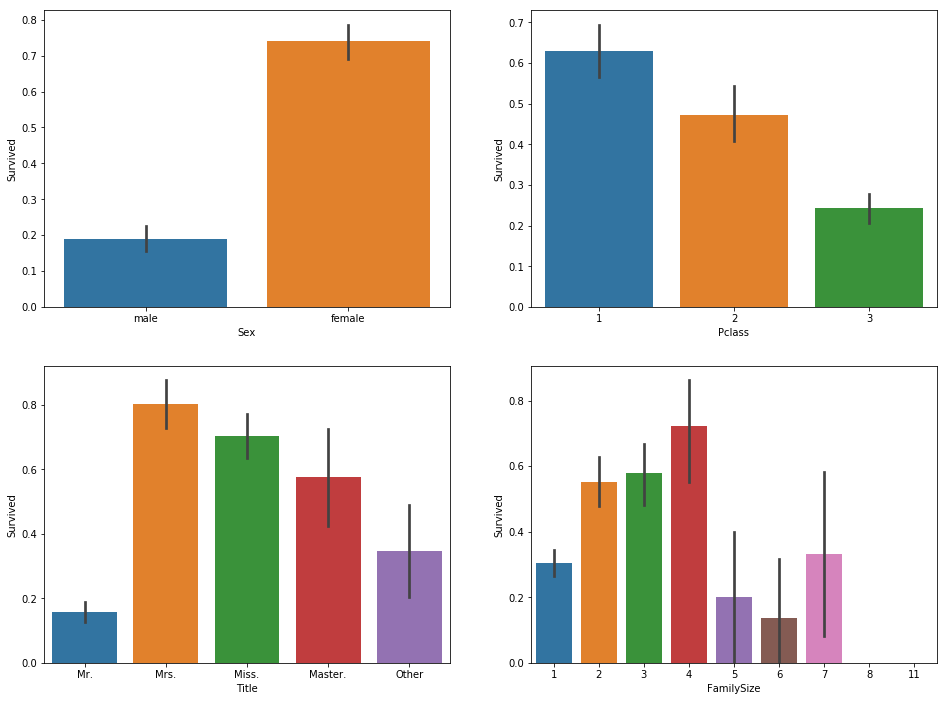

In [131]:
fig, saxis = plt.subplots(2, 2, figsize= (16,12))
sns.barplot(x='Sex', y='Survived', data=df1, ax = saxis[0,0])
sns.barplot(x='Pclass', y='Survived', data=df1, ax = saxis[0,1])
sns.barplot(x='Title', y='Survived', data=df1, ax = saxis[1,0])
sns.barplot(x='FamilySize', y='Survived', data=df1, ax = saxis[1,1])

## Model Comparison

In [133]:
#buld an algo chart to come up with a comparison matrix
#Machine Learning Classifier list
MLC = [
    #ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.BaggingClassifier(),
    
    #linear models
    linear_model.LogisticRegression(),
    linear_model.Perceptron(),
    
    #naives bayes
    naive_bayes.GaussianNB(),
    naive_bayes.MultinomialNB(),
    
    
    #SVM
    svm.LinearSVC(),
    
    #Trees
    tree.DecisionTreeClassifier(),
    
    #booster
    XGBClassifier(),
    lgb.LGBMClassifier()
    ]

MLC_col = ['MLC Name', 'MLC Parameters','MLC Train Accuracy Mean', 'MLC Test Accuracy Mean', 'MLC Test Accuracy 3*STD' ,'MLC Time']
MLC_grid = pd.DataFrame(columns = MLC_col)

k_fold = model_selection.KFold(n_splits=10, random_state=15)

row_num = 0
k_fold = model_selection.KFold(n_splits=4, random_state=15)
MLC_pred = df1[Target]

for x in MLC:
    #MLC NAME
    MLC_name = x.__class__.__name__
    MLC_grid.loc[row_num, 'MLC Name'] = MLC_name
    
    #MLC Parameters
    MLC_grid.loc[row_num, 'MLC Parameters'] = str(x.get_params())
    
    results = model_selection.cross_validate(x, df1[df1_x_bin], df1[Target], cv = k_fold)
    
    #MLC Train Accuracy MeanMLC Test Accuracy Mean
    MLC_grid.loc[row_num, 'MLC Train Accuracy Mean'] = results['train_score'].mean()
    
    #MLC Test Accuracy Mean
    MLC_grid.loc[row_num, 'MLC Test Accuracy Mean'] = results['test_score'].mean()
    
    #MLC Test Accuracy 3*STD
    MLC_grid.loc[row_num, 'MLC Test Accuracy 3*STD'] = results['test_score'].std()*3
    
    #MLC Time
    MLC_grid.loc[row_num, 'MLC Time'] = results['fit_time'].mean()
    
    x.fit(df1[df1_x_bin], df1[Target])
    MLC_pred[MLC_name] = x.predict(df1[df1_x_bin])
    
    row_num += 1

MLC_grid.sort_values(by='MLC Test Accuracy Mean', ascending = False)

,MLC Name,MLC Parameters,MLC Train Accuracy Mean,MLC Test Accuracy Mean,MLC Test Accuracy 3*STD,MLC Time
11,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.876921,0.819345,0.0680627,0.0443744
2,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.864952,0.818209,0.044254,0.0461946
10,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.852604,0.817098,0.0632654,0.0363567
3,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.893005,0.81373,0.0596801,0.00996011
1,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.893006,0.805882,0.0711652,0.00948012
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.8223,0.802514,0.0804876,0.043391
9,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.897121,0.801388,0.0718485,0.00149649
6,GaussianNB,{'priors': None},0.796108,0.789036,0.0684322,0.00124663
8,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.79237,0.784541,0.0671827,0.0251824
4,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.791249,0.781168,0.0597469,0.00248557


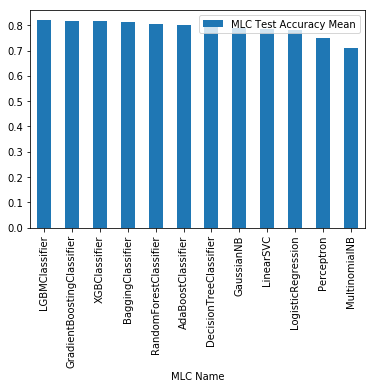

In [148]:
MLC_grid.loc[:, ['MLC Name', 'MLC Test Accuracy Mean']].set_index('MLC Name').sort_values(by='MLC Test Accuracy Mean', ascending=False).plot(kind='bar')

We will use GBMClassifier. We may test GradientBoostingClassifier and XGBClassifier as well. 

## Split Training and Testing Data

In [168]:
# to revisit after Model Comparison